In [2]:
import psycopg2
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import numpy as np
import re
from ckonlpy.tag import Twitter
from pykospacing import Spacing

In [52]:
def tokenWord(keyword) :
    """
    사용자가 입력한 단어를 형태소 단위로 자르고 사이에 %를 삽입하여 DB에서 검색할 수 있도록 변환
    ...
    parameters
        keyword : 검색할 단어 (str)
    ...
    returns
        clean_word : 형태소 단위로 정제된 단어 (str)
    """
    
    twitter = Twitter()
    spacing = Spacing()

    #외래어 읽어오기
    loanwords = pd.read_csv('loanwords.txt', encoding = 'cp949')
    loanwords = loanwords['word'].tolist()
    for word in loanwords :
        twitter.add_dictionary(word, 'Noun')

    #불용어제거 + 토큰화 + %
    clean_word = '%'
    kospacing_word = spacing(keyword) # 띄워쓰기 보완
    tokenized_word = twitter.morphs(kospacing_word) # 토큰화
    for tk in tokenized_word :
        clean_word = clean_word + tk + '%'
    # 여름원피스 -> 여름 원피스 -> ['여름', '원피스'] -> %여름%원피스%
    # 크롭자켓 -> 크롭자켓 -> ['크롭', '자켓'] -> %크롭%자켓%
    
    return clean_word, tokenized_word

In [53]:
keyword = '반팔티셔츠'
clean_word, tokenized_word = tokenWord(keyword)

c:\Users\User\anaconda3\lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


# 포스팅 수 가져오기

In [71]:
def getTitleData(table, clean_word) :
    """
    DB에서 검색 단어가 포함된 데이터를 불러오고 dataFrame 생성 
    ...
    parameters
        table : 데이터가 저장되어 있는 DB 내 테이블 명 (str)
        clean_word : 형태소 단위로 정제된 단어 (str)
    ...
    returns
        df : DB에서 가져온 데이터가 담긴 데이터프레임 (dataFrame; shape[n,4])
    """
    #postgresql 접속
    conn_string = "host='localhost' dbname='postgres' user='postgres' password='admin'"
    conn = psycopg2.connect(conn_string)
    cur = conn.cursor()

    #데이터 가져오기
    command = "select distinct title, date, url, hashtag from " + table + " where title like '" + clean_word + "'"
    print(command)
    cur.execute(command)
    conn.commit()
    data = cur.fetchall()

    #DF화
    df = pd.DataFrame(data)
    df.columns = ['title', 'date', 'url', 'hashtag']

    #db 연결 종료
    conn.cursor().close()
    conn.close()

    return df

In [69]:
def getHashData(table, keyword) :
    """
    DB에서 검색 단어가 포함된 데이터를 불러오고 dataFrame 생성 
    ...
    parameters
        table : 데이터가 저장되어 있는 DB 내 테이블 명 (str)
        keyword : 검색할 단어 (str)
    ...
    returns
        df : DB에서 가져온 데이터가 담긴 데이터프레임 (dataFrame; shape[n,4])
    """
    #postgresql 접속
    conn_string = "host='localhost' dbname='postgres' user='postgres' password='admin'"
    conn = psycopg2.connect(conn_string)
    cur = conn.cursor()

    #데이터 가져오기
    command = "select distinct title, date, url, hashtag from " + table + " where hashtag like '%" + keyword + "%'"
    cur.execute(command)
    conn.commit()
    data = cur.fetchall()

    #DF화
    df = pd.DataFrame(data)
    df.columns = ['title', 'date', 'url', 'hashtag']

    #db 연결 종료
    conn.cursor().close()
    conn.close()

    return df

In [18]:
def dropIrrel(df) :

    #관련 없는 단어 읽어오기
    irrelwords = pd.read_csv('irrelwords.txt')
    irrelwords = irrelwords['word'].tolist()

    #단어가 포함되어 있는 열 삭제
    for word in irrelwords :
        irreldata = df[df['title'].str.contains(word, case = False)].index
        df.drop(irreldata, inplace=True)
    
    return df

In [72]:
yt_title = getTitleData('yt_clothes', clean_word)           #title에 검색어가 포함된 데이터
yt_hash = getHashData('yt_clothes', keyword)                #hashtag에 검색어가 포함된 데이터
yt_data = pd.concat([yt_title, yt_hash], axis=0)            #두 데이터를 합침
yt_data = yt_data.drop_duplicates(['url'])                  #url을 기준으로 중복 데이터 삭제
yt_data = dropIrrel(yt_data)
print('최근 1년 유튜브 게시 영상 수 :', yt_data.shape[0])    #1년 동안의 영상수 반환

select distinct title, date, url, hashtag from yt_clothes where title like '%반팔%티셔츠%'
최근 1년 유튜브 게시 영상 수 : 70


In [55]:
view_title = getTitleData('view_clothes', clean_word)
view_hash = getHashData('view_clothes', keyword)
view_data = pd.concat([view_title, view_hash], axis=0)
view_data = view_data.drop_duplicates(['url'])
view_data = dropIrrel(view_data)
print('최근 1년 네이버뷰 게시글 수 :', view_data.shape[0])

select distinct title, date, url, hashtag from view_clothes where title like '%반팔%티셔츠%'
최근 1년 네이버뷰 게시글 수 : 191


# 워드클라우드

In [21]:
from collections import Counter

def rmEmoji(inputData):
    """
    텍스트에서 이모지 제거
    ...
    parameters
        inputData : 텍스트 (str)
    ...
    returns
        data : 이모지가 제거된 텍스트 (str)
    """

    emoji_pattern = re.compile("["
        u"\U00010000-\U0010FFFF"  #BMP characters 이외
            "]+", flags=re.UNICODE)

    data = emoji_pattern.sub(r'', inputData) # no emoji

    return data

In [56]:
titles = yt_data['title'].tolist()

twitter = Twitter()
spacing = Spacing()

#불용어 읽어오기
stopwords = pd.read_csv("stopwords.txt")
stopwords = stopwords['word'].tolist()
stopwords.extend([',', '.', '+', '[', ']', '!', '?', '(', ')', '|', '_', '~', '#', '/', 'ㅣ'])

#외래어 읽어오기
loanwords = pd.read_csv('loanwords.txt', encoding = 'cp949')
loanwords = loanwords['word'].tolist()
for word in loanwords :
    twitter.add_dictionary(word, 'Noun')

#불용어제거 + 토큰화
tks = []
for sentence in tqdm(titles) :
    reEmoji_sent = rmEmoji(sentence) # 이모티콘 제거
    kospacing_sent = spacing(reEmoji_sent) # 띄워쓰기 보완
    tokenized_sent = twitter.morphs(kospacing_sent) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sent if not word in stopwords] # 불용어 제거
    tks.append(stopwords_removed_sentence)

# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tks)

top15 = Counter(tokenizer.word_counts).most_common(15)

words = dict((x, y) for x, y in top15)
words

100%|██████████| 70/70 [00:04<00:00, 16.19it/s]


{'반팔': 90,
 '티셔츠': 84,
 '여름': 50,
 '코디': 39,
 '추천': 35,
 '티': 35,
 '옷': 19,
 '여자': 14,
 '하울': 13,
 '-': 11,
 '니트': 11,
 '원피스': 10,
 '사이즈': 10,
 '블라우스': 8,
 '리뷰': 8}

In [57]:
#상위 20개 추출
top20 = Counter(tokenizer.word_counts).most_common(20)

words = []
for top in top20 :

    if top[0] in tokenized_word :
        continue #검색어 제거
    else:
        words.append(dict(text=top[0], value=top[1])) #연관어만 딕셔너리화

words

[{'text': '여름', 'value': 50},
 {'text': '코디', 'value': 39},
 {'text': '추천', 'value': 35},
 {'text': '티', 'value': 35},
 {'text': '옷', 'value': 19},
 {'text': '여자', 'value': 14},
 {'text': '하울', 'value': 13},
 {'text': '-', 'value': 11},
 {'text': '니트', 'value': 11},
 {'text': '원피스', 'value': 10},
 {'text': '사이즈', 'value': 10},
 {'text': '블라우스', 'value': 8},
 {'text': '리뷰', 'value': 8},
 {'text': '가지', 'value': 7},
 {'text': '패션', 'value': 7},
 {'text': '&', 'value': 7},
 {'text': '남자', 'value': 7},
 {'text': '내', 'value': 7}]

# 연간 포스팅 추이 
csv 저장 후 태블로에서 진행 예정

In [58]:
#날짜순 정렬
yt_data = yt_data.sort_values(by = 'date')
view_data = view_data.sort_values(by = 'date')


In [84]:
yt_data.date = pd.to_datetime(yt_data.date)     #datetime type으로 변환
yt_data['month'] = yt_data['date'].dt.month     #월추출
yt_count = yt_data.groupby('month').count()     #월별 게시글 개수 카운팅
yt_count = yt_count.reset_index()               #인덱스 초기화
yt_count = yt_count[['month', 'title']]         #필요한 열만 추출
yt_count.columns = ['month', 'num']             #컬럼명 교체
yt_count

,month,num
0,1,1
1,3,4
2,4,9
3,5,34
4,6,10
5,7,7
6,8,3
7,10,1
8,11,1


In [78]:
yt_data.date = pd.to_datetime(yt_data.date)     #datetime type으로 변환
yt_data['month'] = yt_data['date'].dt.month     #월추출

months = ['2021-6','2021-7','2021-8', '2021-9', '2021-10', '2021-11', '2021-12', '2022-1', '2022-2', '2022-3', '2022-4', '2022-5']
cnts = []
    
for month in months :
    month = month.split('-')[1]
    cnt = yt_data[yt_data['month'] == int(month)].shape[0]
    cnts.append(cnt)

cnts

[10, 7, 3, 0, 1, 1, 0, 1, 0, 4, 9, 34]

In [66]:
df_count = pd.DataFrame(data = {'count' : cnts}, index=months)
df_count

,count
6,10
7,7
8,3
9,0
10,1
11,1
12,0
1,1
2,0
3,4


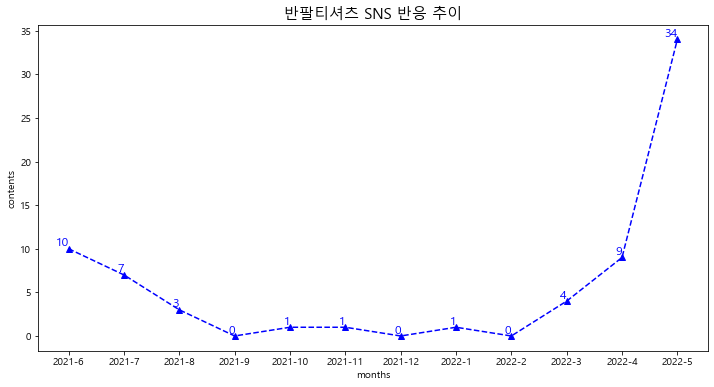

In [100]:
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(12, 6))

plt.plot(months, cnts, 'b^--')

for i, v in enumerate(months):
    plt.text(v, cnts[i], cnts[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 12, 
             color='blue',
             horizontalalignment='right',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.title(keyword + ' SNS 반응 추이', fontsize=15)
plt.xlabel ('months', fontsize=12)
plt.ylabel('contents', fontsize=12)

plt.show()

Text(0, 0.5, 'contents')

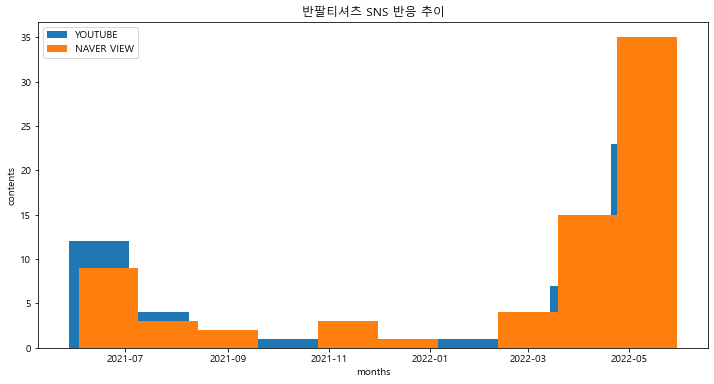

In [85]:
#날짜순 정렬
yt_data = yt_data.sort_values(by = 'date')
view_data = view_data.sort_values(by = 'date')

#날짜별 count
y_day = yt_data['date'].unique()
y_count = yt_data['date'].value_counts().sort_index()
v_day = view_data['date'].unique()
v_count = view_data['date'].value_counts().sort_index()

plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(12, 6))

plt.hist(y_day)
plt.hist(v_day)

plt.title(keyword + ' SNS 반응 추이')
plt.legend(labels = ['YOUTUBE', 'NAVER VIEW'], loc='best')
plt.xlabel ('months')
plt.ylabel('contents')

#plt.plot(y_day, y_count, 'r--')
#plt.plot(y_day, y_count, 'r--', v_day, v_count, 'b^')

# 제목 nlp

In [103]:
yyy['title']

181                올 겨울 주목하면 좋을 아우터!? + 아이템 추천까지! 【패션토크】
184    옷장 속 26가지 가을/겨울 아우터 몽땅 입어보기🧥🍁 FW 자켓, 트렌치, 코트, ...
90     가을,겨울 필수템 / 아우터를 활용한 가을코디 (feat. 남자 가디건 코디 bes...
12     [가을 룩북🍁] FW 아우터 8종 패션하울 l 한섬 아우터 최대 85% 싸게 사는 ...
144                             따라하기 쉬운 가을&겨울 아우터 코디 6가지
                             ...                        
211    한섬 팩토리 아울렛 | 겨울 아우터, 무스탕, 코트 70+30% | 타임, 마인, ...
67     Volg.일상 브이로그, 휘뚤 마뚤 겨울 아우터 lo61 퍼코트, 긴 겨울 나름의 ...
55     haul. 겨울 신상 아이템 하울 | 롱코트 러버가 추천하는 4가지 아우터 🧶 | ...
152    미국 살면 나이키 싸게 사냐구요? ( 겨울 아우터 부터 여름 원피스까지 나이키하울 ...
116    겨울과 봄 사이 패션하울🌷💖 인생 아우터, 니트, 신발, 원피스발견 | 에이블리, ...
Name: title, Length: 214, dtype: object

In [98]:
kkma = Kkma()

def rmEmoji(inputData):

    emoji_pattern = re.compile("["
        u"\U00010000-\U0010FFFF"  #BMP characters 이외
            "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', inputData) # no emoji


In [122]:
#불용어 읽어오기
stopwords = pd.read_csv("stopwords.txt")
stopwords = stopwords['word'].tolist()

#불용어제거 + 토큰화
tk = []
for sentence in tqdm(yyy['title']) :
    sentence = rmEmoji(sentence) # 이모티콘 제거
    tokenized_sentence = kkma.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tk.append(stopwords_removed_sentence)

# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tk)

100%|██████████| 214/214 [00:10<00:00, 19.89it/s]


[['ㄹ',
  '겨울',
  '주목',
  '면',
  '좋',
  '아우터',
  '!',
  '?',
  '+',
  '아이템',
  '추천',
  '!',
  '【',
  '패션',
  '토크',
  '】'],
 ['옷장',
  '속',
  '26',
  '가지',
  '가을',
  '/',
  '겨울',
  '아우터',
  '몽땅',
  '입',
  '보',
  '기',
  'FW',
  '자켓',
  ',',
  '트렌치',
  ',',
  '코트',
  ',',
  '푸',
  '자켓',
  ',',
  '패딩',
  '!'],
 ['가을',
  ',',
  '겨울',
  '필수',
  '템',
  '/',
  '아우터',
  '활용',
  'ㄴ',
  '가을',
  '코디',
  '(',
  'feat',
  '.',
  '남자',
  '디',
  '건',
  '코디',
  'best',
  '20',
  ')']]

# 최근 2개 반환

In [ ]:
#날짜순 정렬
yt_data = yt_data.sort_values(by = 'date')
view_data = view_data.sort_values(by = 'date')

In [113]:
urllist = yt_data.tail(2)['url'].tolist()
urllist

['https://www.youtube.com/watch?v=DqL0JBoydgc',
 'https://www.youtube.com/watch?v=abA5qmSX43c']

In [ ]:
titlelist = yt_data.tail(2)['title'].tolist()

In [112]:
urllist = view_data.tail(2)['url'].tolist()
urllist

['https://blog.naver.com/rhksgn/222751577597',
 'https://blog.naver.com/kagama007/222748977223']

In [118]:
url = 'https://www.youtube.com/watch?v=DqL0JBoydgc'+'/'
print("""href={'%s'}"""%url)
print('<a href="{url}">')

href={'https://www.youtube.com/watch?v=DqL0JBoydgc/'}
<a href="{url}">
